Columns in the dataset: ['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses', 'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter', 'locAbsJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter', 'locShimmer', 'locDbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer', 'meanAutoCorrHarmonicity', 'meanNoiseToHarmHarmonicity', 'meanHarmToNoiseHarmonicity', 'minIntensity', 'maxIntensity', 'meanIntensity', 'f1', 'f2', 'f3', 'f4', 'b1', 'b2', 'b3', 'b4', 'GQ_prc5_95', 'GQ_std_cycle_open', 'GQ_std_cycle_closed', 'GNE_mean', 'GNE_std', 'GNE_SNR_TKEO', 'GNE_SNR_SEO', 'GNE_NSR_TKEO', 'GNE_NSR_SEO', 'VFER_mean', 'VFER_std', 'VFER_entropy', 'VFER_SNR_TKEO', 'VFER_SNR_SEO', 'VFER_NSR_TKEO', 'VFER_NSR_SEO', 'IMF_SNR_SEO', 'IMF_SNR_TKEO', 'IMF_SNR_entropy', 'IMF_NSR_SEO', 'IMF_NSR_TKEO', 'IMF_NSR_entropy', 'mean_Log_energy', 'mean_MFCC_0th_coef', 'mean_MFCC_1st_coef', 'mean_MFCC_2nd_coef', 'mean_MFCC_3rd_coef', 'mean_MFCC_4th_coef', 'mean_MFCC_5th_coef', 'mean_MFCC_6th_

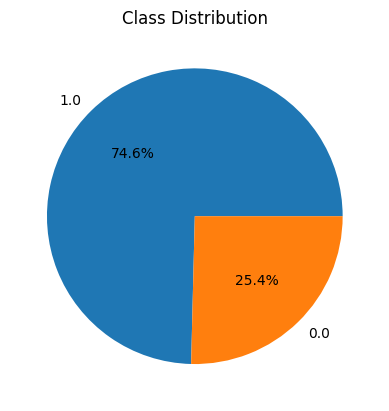

LogisticRegression:
Training AUC: 0.5
Validation AUC: 0.5

XGBClassifier:
Training AUC: 1.0
Validation AUC: 0.7316602316602315

SVC:
Training AUC: 0.7185430463576158
Validation AUC: 0.5694980694980695



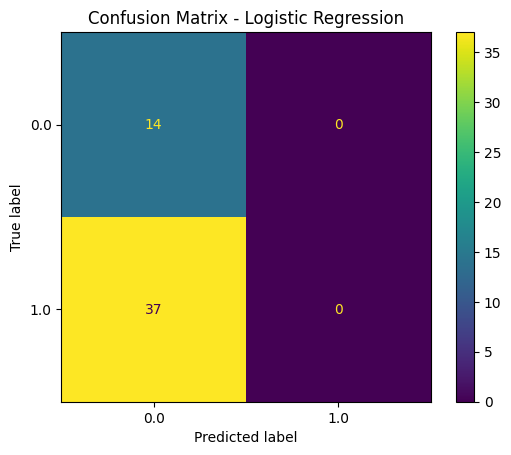

Classification Report:

              precision    recall  f1-score   support

         0.0       0.27      1.00      0.43        14
         1.0       0.00      0.00      0.00        37

    accuracy                           0.27        51
   macro avg       0.14      0.50      0.22        51
weighted avg       0.08      0.27      0.12        51



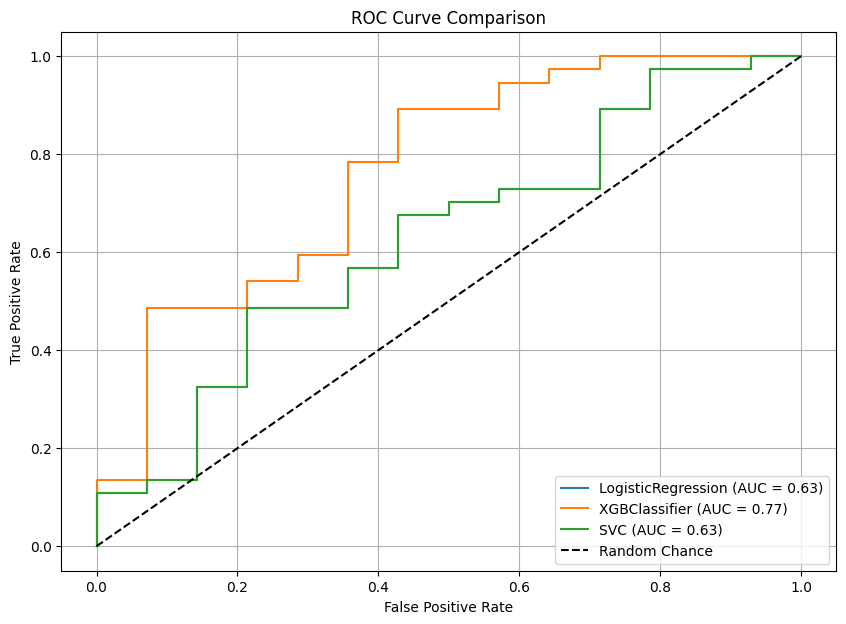

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Logistic Regression Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best Training AUC from GridSearch: 0.7451756272401433
Tuned Logistic Regression Validation AUC: 0.5


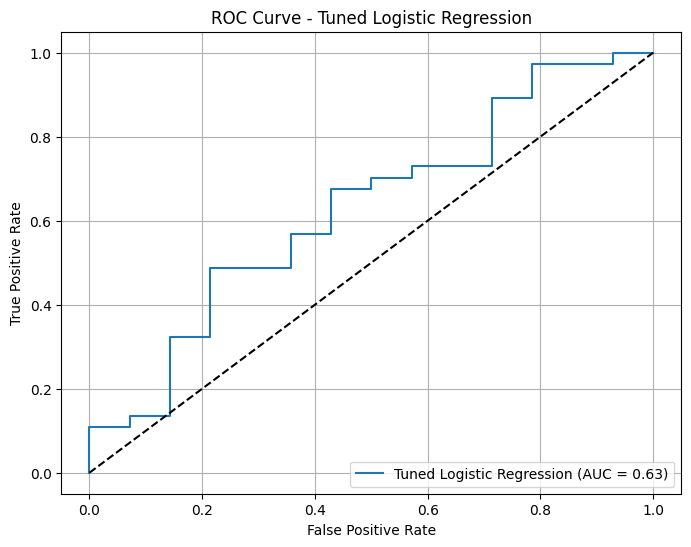

In [6]:
# ===== Imports =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score as ras, roc_curve, auc
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

# ===== Load & Inspect Data =====
df = pd.read_csv('Downloads/parkinson_disease.csv')
pd.set_option('display.max_columns', 10)

# Print columns to inspect
print("Columns in the dataset:", df.columns.tolist())

# Remove duplicates by averaging on 'id' if it exists
if 'id' in df.columns:
    df = df.groupby('id').mean().reset_index()
    df.drop('id', axis=1, inplace=True)
else:
    print("No 'id' column found. Skipping duplicate removal.")

# Identify the target column (assuming it might not be 'class')
# Common names for target in Parkinson's datasets: 'status', 'class', 'label'
possible_target_columns = ['class', 'status', 'label']
target_column = None
for col in possible_target_columns:
    if col in df.columns:
        target_column = col
        break

if target_column is None:
    raise ValueError("No target column ('class', 'status', or 'label') found in the dataset. Please check the dataset.")

print(f"Target column identified: {target_column}")

# ===== Remove Highly Correlated Features =====
columns = list(df.columns)
filtered_columns = []
for col in columns:
    if col == target_column:
        continue
    filtered_columns.append(col)
    for col1 in df.columns:
        if col == col1 or col1 == target_column:
            continue
        if df[col].corr(df[col1]) > 0.7 and col1 in filtered_columns:
            filtered_columns.remove(col1)

df = df[filtered_columns + [target_column]]
print("Columns after removing correlated features:", df.columns.tolist())

# ===== Feature Selection =====
X = df.drop(target_column, axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=min(30, X.shape[1]))  # Ensure k doesn't exceed number of features
selector.fit(X_norm, df[target_column])
selected_cols = selector.get_support()
filtered_data = X.loc[:, selected_cols]
filtered_data[target_column] = df[target_column]
df = filtered_data

# ===== Class Distribution =====
x = df[target_column].value_counts()
plt.pie(x.values, labels=x.index, autopct='%1.1f%%')
plt.title("Class Distribution")
plt.show()

# ===== Train/Test Split =====
features = df.drop(target_column, axis=1)
target = df[target_column]
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=10)

# ===== Oversampling =====
ros = RandomOverSampler(sampling_strategy=1.0, random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, Y_train)

# ===== Train Models =====
models = [
    LogisticRegression(class_weight='balanced', max_iter=1000),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    SVC(kernel='rbf', probability=True)
]

for model in models:
    model.fit(X_resampled, y_resampled)
    print(f'{model.__class__.__name__}:')
    train_preds = model.predict(X_resampled)
    print('Training AUC:', ras(y_resampled, train_preds))
    val_preds = model.predict(X_val)
    print('Validation AUC:', ras(Y_val, val_preds))
    print()

# ===== Confusion Matrix for First Model =====
ConfusionMatrixDisplay.from_estimator(models[0], X_val, Y_val)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ===== Classification Report =====
print("Classification Report:\n")
print(classification_report(Y_val, models[0].predict(X_val)))

# ===== ROC Curve Plot for All Models =====
plt.figure(figsize=(10, 7))
for model in models:
    y_probs = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(Y_val, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# ===== Logistic Regression Hyperparameter Tuning =====
log_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced']
}

log_grid = GridSearchCV(LogisticRegression(max_iter=1000),
                        log_param_grid,
                        scoring='roc_auc',
                        cv=5,
                        verbose=1)

log_grid.fit(X_resampled, y_resampled)

print("Best Logistic Regression Parameters:", log_grid.best_params_)
print("Best Training AUC from GridSearch:", log_grid.best_score_)

# ===== Evaluate Tuned Logistic Regression =====
best_log_reg = log_grid.best_estimator_
val_probs = best_log_reg.predict_proba(X_val)[:, 1]
val_preds = best_log_reg.predict(X_val)
print("Tuned Logistic Regression Validation AUC:", ras(Y_val, val_preds))

# ===== ROC Curve for Tuned Logistic Regression =====
fpr, tpr, _ = roc_curve(Y_val, val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Tuned Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()